Import Pandas and load in SVV credentials.

In [17]:
import pandas as pd

In [18]:
svv_credentials = open('svv_creds.json.txt').read()
import json
svv_creds = json.loads(svv_credentials)

Connect to SVV and Query the Gender table

In [19]:
import psycopg2

def get_svv_connection():
    con = psycopg2.connect(dbname = 'svv', host = 'svv-rs-prod-bi.cjddijbnvfpr.eu-west-1.redshift.amazonaws.com', \
                           port = 5439, user = svv_creds['user'], password = svv_creds['password'])
    return con

In [20]:
query_data = "SELECT * FROM sandbox.rw_gender_experian_validation"

df_gender = pd.DataFrame()

try:
    con = get_svv_connection()
    
    cur = con.cursor()
    cur.execute(query_data)
    
    colnames = [desc[0] for desc in cur.description]
    df_gender = pd.DataFrame(cur.fetchall(), columns = colnames)
    
except Exception as inst:
    print(inst)
finally:
    cur.close()
    con.close()

In [21]:
df_gender.head()

,viewer_id,gender,e_gender
0,8d5388fb-e9ac-448a-84b4-b67a963a6d65,M,M
1,1d0a06f3-a43c-4722-98b3-caf8244f4b08,F,F
2,52cd981f-4ec0-49d4-bb9e-71483e3adabb,M,F
3,f56518de-50e7-4fff-87b1-c476b84e579b,F,F
4,849cdd11-9f1a-4564-a571-eaf8b5390ca2,M,None


Set the viewer_id as the index

In [22]:
df_gender.set_index('viewer_id', inplace = True)
df_gender.head()

,gender,e_gender
viewer_id,,
8d5388fb-e9ac-448a-84b4-b67a963a6d65,M,M
1d0a06f3-a43c-4722-98b3-caf8244f4b08,F,F
52cd981f-4ec0-49d4-bb9e-71483e3adabb,M,F
f56518de-50e7-4fff-87b1-c476b84e579b,F,F
849cdd11-9f1a-4564-a571-eaf8b5390ca2,M,None


Generate a new column to check whether the genders are the same between the Viewer table and the Experian data.

In [23]:
import numpy as np

df_gender['same'] = np.where(df_gender['gender'] == df_gender['e_gender'], 1, 0)
df_gender.head()

,gender,e_gender,same
viewer_id,,,
8d5388fb-e9ac-448a-84b4-b67a963a6d65,M,M,1
1d0a06f3-a43c-4722-98b3-caf8244f4b08,F,F,1
52cd981f-4ec0-49d4-bb9e-71483e3adabb,M,F,0
f56518de-50e7-4fff-87b1-c476b84e579b,F,F,1
849cdd11-9f1a-4564-a571-eaf8b5390ca2,M,None,0


In [24]:
df_gender.dtypes

gender      object
e_gender    object
same         int32
dtype: object

In [25]:
df_gender['same'].sum(axis = 0)

61257

61,257 of the 100,000 sample have the same gender in the Viewer table as they do in the Experian Data (~61.3%)

In [26]:
df_gender_disagreement = df_gender.loc[df_gender['same'] == 0]
df_gender_disagreement.head()

,gender,e_gender,same
viewer_id,,,
52cd981f-4ec0-49d4-bb9e-71483e3adabb,M,F,0
849cdd11-9f1a-4564-a571-eaf8b5390ca2,M,None,0
01580f16-db82-4e11-bbdc-5035ed0c8982,M,None,0
ab2311aa-428e-42cf-81c7-566914207e75,M,None,0
942ec2ef-6b43-4b4c-a7dd-414ee73dc479,M,None,0


In [44]:
df_gender_diff = df_gender_disagreement.loc[df_gender_disagreement['e_gender'].notnull()]
df_gender_diff.head()

,gender,e_gender,same
viewer_id,,,
52cd981f-4ec0-49d4-bb9e-71483e3adabb,M,F,0
46534b48-490d-47f4-b790-d85fc3232879,M,F,0
38b42cda-fa75-45f3-bbae-a3ea073e7144,F,M,0
7fd860f8-66e8-4547-814d-e39d7fcdafdd,F,M,0
eeb5aed3-8164-464f-a72f-437ad186275a,F,M,0


In [45]:
df_gender_diff_v_m = df_gender_diff.loc[df_gender_diff['gender'] == 'M']
df_gender_diff_v_m.head()

,gender,e_gender,same
viewer_id,,,
52cd981f-4ec0-49d4-bb9e-71483e3adabb,M,F,0
46534b48-490d-47f4-b790-d85fc3232879,M,F,0
db1a63d7-c969-4a43-a3c2-5cc3ff79905c,M,F,0
33caf625-156e-41f2-a971-6b66b3196c96,M,F,0
f5dfef86-fd2f-493e-9e6e-c3aec098debf,M,F,0


In [46]:
len(df_gender_diff_v_m)

2647

2,647 users are listed as Male in the viewer table who are listed as Female from Experian (from the 100,000 user sample, ~2.6%)

In [47]:
df_gender_diff_v_f = df_gender_diff.loc[df_gender_diff['gender'] == 'F']
df_gender_diff_v_f.head()

,gender,e_gender,same
viewer_id,,,
38b42cda-fa75-45f3-bbae-a3ea073e7144,F,M,0
7fd860f8-66e8-4547-814d-e39d7fcdafdd,F,M,0
eeb5aed3-8164-464f-a72f-437ad186275a,F,M,0
f1dea152-0c41-4dcb-851e-ae07041b829e,F,M,0
99879e82-fa4d-4c19-b87e-787318c439c8,F,M,0


In [48]:
len(df_gender_diff_v_f)

3344

3,344 users are listed as Female in the Viewer table who are listed as Male in Experian (from the 100,000 sample, ~3.3%)

In [49]:
df_experian_null = df_gender.loc[df_gender['e_gender'].isnull()]
df_experian_null.head()

,gender,e_gender,same
viewer_id,,,
849cdd11-9f1a-4564-a571-eaf8b5390ca2,M,None,0
01580f16-db82-4e11-bbdc-5035ed0c8982,M,None,0
ab2311aa-428e-42cf-81c7-566914207e75,M,None,0
942ec2ef-6b43-4b4c-a7dd-414ee73dc479,M,None,0
593a6217-f1d1-435e-a69d-11777df88fb8,F,None,0


In [50]:
len(df_experian_null)

32591

32.6% of the Experian sample had Null genders

61,257 / 67,248 (91.09%) of the viewers where neither the viewer nor Experian genders are null agree with each other.

In [51]:
import psycopg2

def get_svv_connection():
    con = psycopg2.connect(dbname = 'svv', host = 'svv-rs-prod-bi.cjddijbnvfpr.eu-west-1.redshift.amazonaws.com', \
                           port = 5439, user = svv_creds['user'], password = svv_creds['password'])
    return con

In [52]:
query_data = "SELECT * FROM sandbox.rw_gender_experian_validation_nonnull"

df_gender_nonnull = pd.DataFrame()

try:
    con = get_svv_connection()
    
    cur = con.cursor()
    cur.execute(query_data)
    
    colnames = [desc[0] for desc in cur.description]
    df_gender_nonnull = pd.DataFrame(cur.fetchall(), columns = colnames)
    
except Exception as inst:
    print(inst)
finally:
    cur.close()
    con.close()

In [53]:
df_gender_nonnull.head()

,viewer_id,gender,e_gender
0,8d5388fb-e9ac-448a-84b4-b67a963a6d65,M,M
1,8e267207-01d8-40ce-ae7f-3155d0907d00,M,M
2,f56518de-50e7-4fff-87b1-c476b84e579b,F,F
3,d1de40ba-5c13-4732-83b5-d37aa4313ec7,M,M
4,725abd85-4927-45e8-a8fa-80bb76573f77,F,F


In [54]:
df_gender_nonnull.set_index('viewer_id', inplace = True)
df_gender_nonnull.head()

,gender,e_gender
viewer_id,,
8d5388fb-e9ac-448a-84b4-b67a963a6d65,M,M
8e267207-01d8-40ce-ae7f-3155d0907d00,M,M
f56518de-50e7-4fff-87b1-c476b84e579b,F,F
d1de40ba-5c13-4732-83b5-d37aa4313ec7,M,M
725abd85-4927-45e8-a8fa-80bb76573f77,F,F


In [55]:
df_gender_nonnull['same'] = np.where(df_gender_nonnull['gender'] == df_gender_nonnull['e_gender'], 1, 0)
df_gender_nonnull.head()

,gender,e_gender,same
viewer_id,,,
8d5388fb-e9ac-448a-84b4-b67a963a6d65,M,M,1
8e267207-01d8-40ce-ae7f-3155d0907d00,M,M,1
f56518de-50e7-4fff-87b1-c476b84e579b,F,F,1
d1de40ba-5c13-4732-83b5-d37aa4313ec7,M,M,1
725abd85-4927-45e8-a8fa-80bb76573f77,F,F,1


In [56]:
df_gender_nonnull['same'].sum(axis = 0)

90832

In [57]:
df_gender_nonnull_disagreement = df_gender_nonnull.loc[df_gender_nonnull['same'] == 0]
df_gender_nonnull_disagreement.head()

,gender,e_gender,same
viewer_id,,,
97f5fb19-8601-4508-b160-d6e79d5a1f7a,F,M,0
7bafc2a3-8805-4dc6-93e6-47784ccd9ee1,F,M,0
ee0e5c98-2d9f-4c2b-8a73-180da62f2aec,F,M,0
2627e066-6cc0-4ea9-a1ef-1f7d4c8e1978,F,M,0
b223506c-8a7c-4a41-a1c9-eca27b4781bc,M,F,0


In [58]:
df_gender_nonnull_diff_v_m = df_gender_nonnull_disagreement.loc[df_gender_nonnull_disagreement['gender'] == 'M']
df_gender_nonnull_diff_v_m.head()

,gender,e_gender,same
viewer_id,,,
b223506c-8a7c-4a41-a1c9-eca27b4781bc,M,F,0
5827b172-2a21-4923-83ee-2d6e8fc2f0e3,M,F,0
c7e89c8d-f680-4118-a322-f25b7c258f8e,M,F,0
746e5ac1-368d-4631-8c04-8c5f26983bf0,M,F,0
a44a309f-9e41-4e53-871b-999ab1c71449,M,F,0


In [60]:
len(df_gender_nonnull_diff_v_m)

3910

In [61]:
df_gender_nonnull_diff_v_f = df_gender_nonnull_disagreement.loc[df_gender_nonnull_disagreement['gender'] == 'F']
df_gender_nonnull_diff_v_f.head()

,gender,e_gender,same
viewer_id,,,
97f5fb19-8601-4508-b160-d6e79d5a1f7a,F,M,0
7bafc2a3-8805-4dc6-93e6-47784ccd9ee1,F,M,0
ee0e5c98-2d9f-4c2b-8a73-180da62f2aec,F,M,0
2627e066-6cc0-4ea9-a1ef-1f7d4c8e1978,F,M,0
4537edc7-b466-46b6-a900-beab9e394f39,F,M,0


In [62]:
len(df_gender_nonnull_diff_v_f)

5011

90.83% of the Users in this 100,000 sample have genders that agrre in the viewer table and in the Experian data.

3.91% of the Users in this sample are recorded as Male in the viewer table but they are listed as Female in the Experian data.

5.01% of the USers in the sample are labelled as Female in the viewer table but are Male in the Experian data.

In [63]:
import psycopg2

def get_svv_connection():
    con = psycopg2.connect(dbname = 'svv', host = 'svv-rs-prod-bi.cjddijbnvfpr.eu-west-1.redshift.amazonaws.com', \
                           port = 5439, user = svv_creds['user'], password = svv_creds['password'])
    return con

In [64]:
query_data = "SELECT * FROM sandbox.rw_experian_age_verification"

df_age = pd.DataFrame()

try:
    con = get_svv_connection()
    
    cur = con.cursor()
    cur.execute(query_data)
    
    colnames = [desc[0] for desc in cur.description]
    df_age = pd.DataFrame(cur.fetchall(), columns = colnames)
    
except Exception as inst:
    print(inst)
finally:
    cur.close()
    con.close()

In [65]:
df_age.head()

,age,p_age_fine,v_age_fine,band_diff
0,42,04,4.0,0
1,58,07,7.0,0
2,35,02,2.0,0
3,50,09,5.0,-4
4,81,09,11.0,2


In [67]:
df_age.dtypes

age             int64
p_age_fine     object
v_age_fine    float64
band_diff      object
dtype: object

In [69]:
df_age = df_age.dropna(0)

In [70]:
df_age['p_age_fine'] = df_age['p_age_fine'].astype(int)
df_age['v_age_fine'] = df_age['v_age_fine'].astype(int)
df_age['band_diff'] = df_age['band_diff'].astype(int)

In [71]:
df_age_agree = df_age.loc[df_age['band_diff'] == 0]
len(df_age_agree)

51069

In [72]:
len(df_age)

98686

51,069 / 98,686 (51.7%) of age band from the Viewer table and Experian table agree with one another

In [73]:
df_age_v_lower = df_age.loc[df_age['band_diff'] < 0]
len(df_age_v_lower)

32011

32,011 / 98,686 (32.4%) of age bands are lower in the Viewer table than in the Experian data, implying that Experian has modelled them as older

In [74]:
df_age_v_higher = df_age.loc[df_age['band_diff'] > 0]
len(df_age_v_higher)

15606

15,606 / 98,686 (15.8%) of age bands are higher in the Viewer table than they are in the Experian data, implying that the are older in the Viewer table.

In [95]:
df_age_hist = df_age.loc[:,['band_diff']]
df_age_hist.head()

,band_diff
0,0
1,0
2,0
3,-4
4,2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023964875438>]],
      dtype=object)

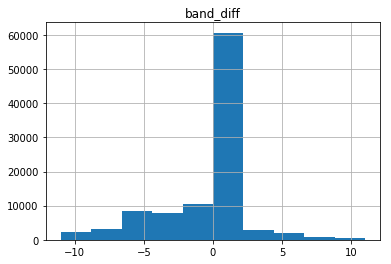

In [98]:
%matplotlib inline

pd.DataFrame.hist(df_age_hist)

In [99]:
df_age_hist['band_diff'] = df_age_hist['band_diff'].abs()
df_age_hist.head()

,band_diff
0,0
1,0
2,0
3,4
4,2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000239691F2198>]],
      dtype=object)

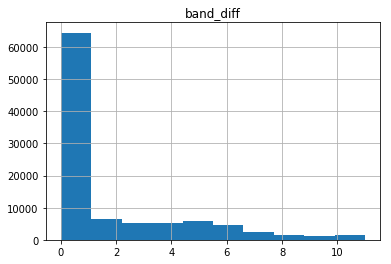

In [100]:
pd.DataFrame.hist(df_age_hist)

In [76]:
import psycopg2

def get_svv_connection():
    con = psycopg2.connect(dbname = 'svv', host = 'svv-rs-prod-bi.cjddijbnvfpr.eu-west-1.redshift.amazonaws.com', \
                           port = 5439, user = svv_creds['user'], password = svv_creds['password'])
    return con

In [77]:
query_data = "SELECT * FROM sandbox.rw_hc_experian_verification"

df_hc = pd.DataFrame()

try:
    con = get_svv_connection()
    
    cur = con.cursor()
    cur.execute(query_data)
    
    colnames = [desc[0] for desc in cur.description]
    df_hc = pd.DataFrame(cur.fetchall(), columns = colnames)
    
except Exception as inst:
    print(inst)
finally:
    cur.close()
    con.close()

In [78]:
df_hc.head()

,viewer_id,h_households_with_children_v3,children
0,acd6a37b-d8c0-4df5-a638-602984c45c99,1,1
1,c651adc4-ce72-4e2a-a712-6fe26ad21897,0,0
2,78d7f6a2-cc7b-40a2-ac58-8c1cf3e52645,0,0
3,026ae188-1c8b-4709-a01a-16a2fef5bfd5,0,0
4,0e06ac8a-1cf9-4033-8c2a-fbaffae39a5f,0,0


In [79]:
df_hc.set_index('viewer_id', inplace = True)
df_hc.head()

,h_households_with_children_v3,children
viewer_id,,
acd6a37b-d8c0-4df5-a638-602984c45c99,1,1
c651adc4-ce72-4e2a-a712-6fe26ad21897,0,0
78d7f6a2-cc7b-40a2-ac58-8c1cf3e52645,0,0
026ae188-1c8b-4709-a01a-16a2fef5bfd5,0,0
0e06ac8a-1cf9-4033-8c2a-fbaffae39a5f,0,0


In [80]:
df_hc.dtypes

h_households_with_children_v3    object
children                          int64
dtype: object

In [82]:
df_hc = df_hc.dropna(0)

In [86]:
df_hc.groupby('h_households_with_children_v3').count()

,children
h_households_with_children_v3,
0,60510
1,39360
U,130


In [87]:
df_hc = df_hc.loc[df_hc['h_households_with_children_v3'] != 'U']

In [88]:
df_hc.groupby('h_households_with_children_v3').count()

,children
h_households_with_children_v3,
0,60510
1,39360


In [89]:
df_hc['h_households_with_children_v3'] = df_hc['h_households_with_children_v3'].astype(int)

In [90]:
df_hc['difference'] = df_hc['children'] - df_hc['h_households_with_children_v3']
df_hc.head()

,h_households_with_children_v3,children,difference
viewer_id,,,
acd6a37b-d8c0-4df5-a638-602984c45c99,1,1,0
c651adc4-ce72-4e2a-a712-6fe26ad21897,0,0,0
78d7f6a2-cc7b-40a2-ac58-8c1cf3e52645,0,0,0
026ae188-1c8b-4709-a01a-16a2fef5bfd5,0,0,0
0e06ac8a-1cf9-4033-8c2a-fbaffae39a5f,0,0,0


In [91]:
len(df_hc)

99870

In [92]:
df_hc_agree = df_hc.loc[df_hc['difference'] == 0]
len(df_hc_agree)

97417

97,417 / 99,870 (97.5%) of Users agree between the Viewer table and the Experian data as to whether they have children in their households or not.

In [93]:
df_hc_v_1 = df_hc.loc[(df_hc['difference'] == 1) & (df_hc['children'] == 1)]
len(df_hc_v_1)

0

In [94]:
df_hc_e_1 = df_hc.loc[(df_hc['difference'] == -1) & (df_hc['children'] == 0)]
len(df_hc_e_1)

2453

2,453 / 99,870 (2.5%) of Users are listed as not having children in the household in the viewer table but do have children in the Experian data.

In [101]:
import psycopg2

def get_svv_connection():
    con = psycopg2.connect(dbname = 'svv', host = 'svv-rs-prod-bi.cjddijbnvfpr.eu-west-1.redshift.amazonaws.com', \
                           port = 5439, user = svv_creds['user'], password = svv_creds['password'])
    return con

In [102]:
query_data = "SELECT * FROM sandbox.rw_aa_experian_verification"

df_aa = pd.DataFrame()

try:
    con = get_svv_connection()
    
    cur = con.cursor()
    cur.execute(query_data)
    
    colnames = [desc[0] for desc in cur.description]
    df_aa = pd.DataFrame(cur.fetchall(), columns = colnames)
    
except Exception as inst:
    print(inst)
finally:
    cur.close()
    con.close()

In [103]:
df_aa.head()

,viewer_id,abc1,p_personal_income_value_v3,h_income_value_v3
0,74760de0-9f59-41d6-9747-92b0c8ea6bb3,0,29200,29200
1,0bf036c1-b747-4fb1-a064-a26c8d8248ea,0,12000,33600
2,0a3deaa7-48e2-4a22-a061-76ac5c7789b9,0,28800,28800
3,78247b4f-9993-4ff0-bea7-0f6ae7547435,0,7900,7900
4,a53499b2-4a95-4928-86ac-173492ff1b19,0,13200,13200


In [104]:
df_aa.set_index('viewer_id', inplace = True)
df_aa.head()

,abc1,p_personal_income_value_v3,h_income_value_v3
viewer_id,,,
74760de0-9f59-41d6-9747-92b0c8ea6bb3,0,29200,29200
0bf036c1-b747-4fb1-a064-a26c8d8248ea,0,12000,33600
0a3deaa7-48e2-4a22-a061-76ac5c7789b9,0,28800,28800
78247b4f-9993-4ff0-bea7-0f6ae7547435,0,7900,7900
a53499b2-4a95-4928-86ac-173492ff1b19,0,13200,13200


In [108]:
df_aa['exp_abc1'] = np.where((df_aa['p_personal_income_value_v3'] >= 32000) ^ (df_aa['h_income_value_v3'] >= 40000), 1, 0)
df_aa.head()

,abc1,p_personal_income_value_v3,h_income_value_v3,exp_abc1
viewer_id,,,,
74760de0-9f59-41d6-9747-92b0c8ea6bb3,0,29200,29200,0
0bf036c1-b747-4fb1-a064-a26c8d8248ea,0,12000,33600,0
0a3deaa7-48e2-4a22-a061-76ac5c7789b9,0,28800,28800,0
78247b4f-9993-4ff0-bea7-0f6ae7547435,0,7900,7900,0
a53499b2-4a95-4928-86ac-173492ff1b19,0,13200,13200,0


In [111]:
df_aa_reduced = df_aa.loc[:, ['abc1', 'exp_abc1']]
df_aa_reduced.head()

,abc1,exp_abc1
viewer_id,,
74760de0-9f59-41d6-9747-92b0c8ea6bb3,0,0
0bf036c1-b747-4fb1-a064-a26c8d8248ea,0,0
0a3deaa7-48e2-4a22-a061-76ac5c7789b9,0,0
78247b4f-9993-4ff0-bea7-0f6ae7547435,0,0
a53499b2-4a95-4928-86ac-173492ff1b19,0,0


In [112]:
df_aa_reduced.dtypes

abc1        int64
exp_abc1    int32
dtype: object

In [113]:
df_aa_reduced['difference'] = abs(df_aa_reduced['abc1'] - df_aa_reduced['exp_abc1'])
df_aa_reduced.head()

,abc1,exp_abc1,difference
viewer_id,,,
74760de0-9f59-41d6-9747-92b0c8ea6bb3,0,0,0
0bf036c1-b747-4fb1-a064-a26c8d8248ea,0,0,0
0a3deaa7-48e2-4a22-a061-76ac5c7789b9,0,0,0
78247b4f-9993-4ff0-bea7-0f6ae7547435,0,0,0
a53499b2-4a95-4928-86ac-173492ff1b19,0,0,0


In [114]:
len(df_aa_reduced)

100000

In [115]:
df_aa_agree = df_aa_reduced.loc[df_aa_reduced['difference'] == 0]
len(df_aa_agree)

72400

72,400 / 100,000 (72.4%) of barb and Experian data agree on whether the viewer is ABC1

In [116]:
df_aa_disagree_v_abc1 = df_aa_reduced.loc[(df_aa_reduced['difference'] == 1) & (df_aa_reduced['abc1'] == 1)]
len(df_aa_disagree_v_abc1)

26846

26,846 / 100,000 (26.8%) of viewers are listed as ABC1 in the Viewer table but are not in the Experian table

In [117]:
df_aa_disagree_v_c2de = df_aa_reduced.loc[(df_aa_reduced['difference'] == 1) & (df_aa_reduced['abc1'] == 0)]
len(df_aa_disagree_v_c2de)

754

754 / 100,000 (0.75%) of viewers are not listed as ABC1 in the Viewer table but are in the Experian table.